In [37]:
%matplotlib inline

import fiona
import rasterio
from rasterio.tools.mask import mask
import numpy as np
import pandas as pd
import progressbar
import os 

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.cm as cm

import itertools
from collections import deque

import scipy.stats
import scipy.spatial.distance

import Data, Figures, Models

Data = reload(Data)
Figures = reload(Figures)
Models = reload(Models)

figureOutputDir = "/home/caleb/Dropbox/CalebBistra/Papers/PNAS_2016/figures/"

In [2]:
shapefile = fiona.open("data/countyBoundaries/countyBoundaries2.shp", "r")
counties = list(shapefile)
shapefile.close()

In [3]:
src = rasterio.open("data/usRaster.tif")
noData = src.nodatavals
data = src.read()
src.close()

# rasterio returns a 3-dimensional array of shape (1,width,height), we need to remove the first axis to visualize
data = data.squeeze()


plt.figure(figsize=(16, 8))
plt.imshow(data, interpolation='bilinear', cmap=cm.gray, alpha=1.0)
plt.grid(False)
plt.show()

# Figure 1

Plot the following 3 values where the sea level rise amount varies from 0-10m

- total amount of land affected
- total amount of population affected
- population density of displaced areas


TODO

- Make plots for florida
- Change code to allow for individual levels of sea level rise (don't assume [0,x])

In [16]:
startSeaLevelRise = 0
stopSeaLevelRise = 10
seaLevelRiseRange = range(startSeaLevelRise,stopSeaLevelRise+1)

startYear = 2013
stopYear = 2013
yearRange = range(startYear,stopYear+1)


populationDataSets, migrationDataSets = Data.loadMigrationPopulationDataset(yearRange, zeroSelfMigration=False)
        
countyIds = Data.loadCounties()
countyIdMap = {countyId:i for i,countyId in enumerate(countyIds)} #mapping from countyId to position in list
countyIndex_IdMap = {i:countyId for i,countyId in enumerate(countyIds)}
countyNameMapping = Data.loadCountyNameMap() #mapping from countyId to name

distanceMatrix = Data.loadCountyPairwiseDistanceMatrix()

Loading the distance matrix


## Calculate Per County Statistics

In [17]:
countyPopulationAffected = [] # 1 dictionary for each number in seaLevelRiseRange
countyLandAmountAffected = [] # 1 dictionary for each number in seaLevelRiseRange
countyTotalLand = []
percentLandAffected = []

countyNames = dict()
goodCounties = set()

bar = progressbar.ProgressBar()
for x in bar(seaLevelRiseRange):

    tempCountyPopulationAffected = dict()
    tempCountyLandAmountAffected = dict()
    tempCountyTotalLand = dict()
    totalLand = 0.0
    
    for county in counties:
        
        countyId = int(county["properties"]['GEOID'])
        countyName = countyNameMapping[countyId]
        if countyId in countyIds:
            try:
                geoms = [county["geometry"]]

                #src = rasterio.open("usRaster.tif")
                src = rasterio.open("outputs/mask_%d.tif" % (x))
                out_image, out_transform = mask(src, geoms, crop=True, nodata=-999)
                src.close()

                numZero = np.sum(out_image == -999.0)
                numAffected = np.sum(out_image == 1) #we marked raster as 1 if it was reachable by sea level rise
                numNotAffected = np.sum(out_image == 0)

                assert numZero + numAffected + numNotAffected == out_image.count()

                totalNum = numAffected+numNotAffected

                percentAffected = (numAffected) / float(totalNum)
                totalLand += numAffected

                tempCountyPopulationAffected[countyId] = percentAffected
                tempCountyLandAmountAffected[countyId] = numAffected
                tempCountyTotalLand[countyId] = totalNum

                countyNames[countyId] = countyName
                goodCounties.add(countyId)
            except ValueError as e:
                pass
    
    countyPopulationAffected.append(tempCountyPopulationAffected) #TODO: fix this to be dict
    countyLandAmountAffected.append(tempCountyLandAmountAffected)
    countyTotalLand.append(tempCountyTotalLand)

100% (11 of 11) |#####################################################################################################################################| Elapsed Time: 0:01:05 Time: 0:01:05


## Subfigure 1 - Amount of land affected by sea level rise

In [33]:
yValues = []
for i,x in enumerate(seaLevelRiseRange):
    totalAmountAffected = np.sum(countyLandAmountAffected[i].values())
    yValues.append(totalAmountAffected)

plt.figure(figsize=(8,6))
#plt.title("Amount of Land Affected in Different Scenarios of Sea Level Rise", y=1.04, fontsize=15)
plt.title("Land Affected", y=1.04, fontsize=20)
plt.ylabel("Land Affected (thousands $km^2$)", fontsize=16)
plt.xlabel("Sea Level Rise Amount ($m$)", fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.plot(seaLevelRiseRange, yValues)
plt.scatter(seaLevelRiseRange, yValues, color='r', marker='s')
plt.savefig(os.path.join(figureOutputDir,"fig1_a.png"), dpi=100, alpha=True)
plt.show()

print yValues

[21498, 44555, 64022, 78623, 97272, 114896, 139437, 157984, 175441, 199104, 225577]


### Subfigure 1 for just Florida counties

In [ ]:
yValues = []
for i,x in enumerate(seaLevelRiseRange):
    totalAmountAffected = 0
    for countyId in countyIds:
        if str(countyId)[:-3] == "12": #12 is Florida FIPS code
            totalAmountAffected += countyLandAmountAffected[i][countyId]
    yValues.append(totalAmountAffected)

plt.figure(figsize=(8,6))
plt.title("Florida, Amount of Land Affected in Different Scenarios of Sea Level Rise", y=1.04, fontsize=20)
plt.ylabel("Amount of Land Affected ($km^2$)", fontsize=16)
plt.xlabel("Sea Level Rise Amount ($m$)", fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.scatter(seaLevelRiseRange, yValues)
plt.show()

print yValues

### Subfigure 1 for top k counties

In [ ]:
k=10

countyListByLastAmount = sorted(countyLandAmountAffected[-1], key=countyLandAmountAffected[-1].get, reverse=True)

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for county in countyListByLastAmount[:k]:
    if county in goodCounties:
        yVals = []
        for i,amount in enumerate(seaLevelRiseRange):
            yVals.append(countyLandAmountAffected[i][county])

    ax.plot(seaLevelRiseRange,yVals, label="%s" % countyNames[county])

#move the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.75))

plt.title("Top %d Most Affected Counties by Land Covered" % (k), y=1.04, fontsize=20)
plt.ylabel("Amount of Land Affected ($km^2$)", fontsize=16)
plt.xlabel("Sea Level Rise Amount ($m$)", fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.show()

## Subfigure 2 - Amount of population displaced by sea level rise

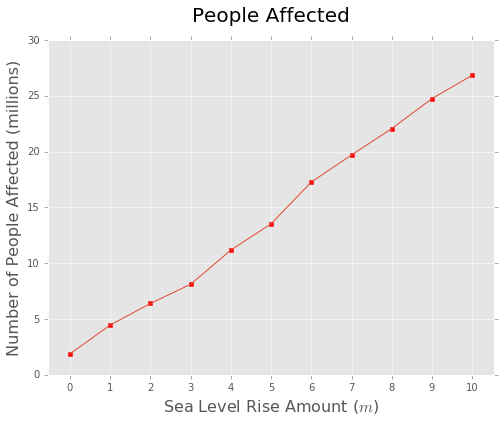

[1881717.7390544778, 4464475.8725881577, 6391623.7510442678, 8117885.2258027578, 11179456.754754063, 13534533.735288238, 17275376.89866244, 19700435.249954455, 22065355.805271715, 24750258.845267393, 26842627.603835233]


In [34]:
yValues = []
for i,x in enumerate(seaLevelRiseRange):    
    tempPopulationCounts = []
    totalPopulation = 0
    
    for countyId in goodCounties:
        tempPopulationCounts.append(countyPopulationAffected[i][countyId] * populationDataSets[0][countyIdMap[countyId]])
        totalPopulation += populationDataSets[0][countyIdMap[countyId]]
            
    totalAmountAffected = np.sum(tempPopulationCounts)
    yValues.append(totalAmountAffected)
    
plt.figure(figsize=(8,6))
#plt.title("Number of People Affected in Different Scenarios of Sea Level Rise", y=1.04, fontsize=15)
plt.title("People Affected", y=1.04, fontsize=20)
plt.ylabel("Number of People Affected (millions)", fontsize=16)
plt.xlabel("Sea Level Rise Amount ($m$)", fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.plot(seaLevelRiseRange, [float(_)/1e6  for _ in yValues])
plt.scatter(seaLevelRiseRange, [float(_)/1e6  for _ in yValues], color='r', marker='s')
plt.savefig(os.path.join(figureOutputDir,"fig1_b.png"), dpi=100, alpha=True)
plt.show()
print yValues

### Subfigure 2 for just Florida

In [ ]:
yValues = []
for i,x in enumerate(seaLevelRiseRange):
    totalAmountAffected = 0
    for countyId in countyIds:
        if str(countyId)[:-3] == "12": #12 is Florida FIPS code
            totalAmountAffected += countyPopulationAffected[x][countyId] * populationDataSets[0][countyIdMap[countyId]]
    yValues.append(totalAmountAffected)

plt.figure(figsize=(8,6))
plt.title("Florida, Number of People Affected in Different Scenarios of Sea Level Rise", y=1.04, fontsize=20)
plt.ylabel("Amount of Population Affected (millions)", fontsize=16)
plt.xlabel("Sea Level Rise Amount ($m$)", fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.scatter(seaLevelRiseRange, [float(_)/1e6  for _ in yValues])
plt.show()

print yValues

### Subfigure 2 for top k counties

In [ ]:
k=10

def sortFunc(countyId):
    return countyPopulationAffected[-1][countyId] * populationDataSets[0][countyIdMap[countyId]]
countyListByLastAmount = sorted(countyLandAmountAffected[-1], key=sortFunc, reverse=True)

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for county in countyListByLastAmount[:k]:
    if county in goodCounties:
        yValues = []
        for i,amount in enumerate(seaLevelRiseRange):
            yValues.append(countyPopulationAffected[i][county] * populationDataSets[0][countyIdMap[county]])
        ax.plot(seaLevelRiseRange,[float(_)/1e6  for _ in yValues], label="%s" % countyNames[county])

#move the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.75))

plt.title("Top %d Most Affected Counties by Population Displaced" % (k), fontsize=16)
plt.ylabel("Amount of Population Affected (millions)", fontsize=16)
plt.xlabel("Sea Level Rise Amount ($m$)", fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.show()

## Subfigure 3 - Population Density of Displaced


This is interpreted as the average number of people per kilometer that are displaced over all counties in continental US 

In [35]:
yValues = []
for i,x in enumerate(seaLevelRiseRange):
    tNum =0
    tDenom = 0
    for countyId in goodCounties:    
        tPopulationAffected = countyPopulationAffected[i][countyId] * populationDataSets[0][countyIdMap[countyId]]
        tLandAffected = countyLandAmountAffected[i][countyId]

        tNum += tPopulationAffected
        tDenom += tLandAffected
    yValues.append(tNum/tDenom)
    
plt.figure(figsize=(8,6))
#plt.title("Affected Population Density in Different Scenarios of Sea Level Rise", y=1.04, fontsize=15)
plt.title("Population Density of Affected Areas", y=1.04, fontsize=20)
plt.ylabel("Mean Population Density", fontsize=16)
plt.xlabel("Sea Level Rise Amount ($m$)", fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.ylim(80,130)
plt.plot(seaLevelRiseRange, yValues)
plt.scatter(seaLevelRiseRange, yValues, color='r', marker='s')
plt.savefig(os.path.join(figureOutputDir,"fig1_c.png"), dpi=100, alpha=True)
plt.show()
print yValues

[87.529897620917168, 100.2014560114052, 99.834802896570906, 103.2507691871686, 114.92985396366956, 117.79812817929464, 123.89377925989822, 124.6989267897664, 125.77080503001982, 124.30819493966672, 118.99541001004189]


### Subfigure 3 for just Florida

In [ ]:
yValues = []
for i,x in enumerate(seaLevelRiseRange):
    tNum =0
    tDenom = 0
    for countyId in countyIds:
        if str(countyId)[:-3] == "12": #12 is Florida FIPS code
            tPopulationAffected = countyPopulationAffected[i][countyId] * populationDataSets[0][countyIdMap[countyId]]
            tLandAffected = countyLandAmountAffected[i][countyId]

            tNum += tPopulationAffected
            tDenom += tLandAffected
    yValues.append(tNum/tDenom)
    
plt.figure(figsize=(8,6))
plt.title("Florida, Affected Population Density in Different Scenarios of Sea Level Rise", y=1.04, fontsize=20)
plt.ylabel("Mean Population Density of Affected Areas", fontsize=16)
plt.xlabel("Sea Level Rise Amount ($m$)", fontsize=16)
plt.xticks(np.arange(0, 11, 1))
plt.scatter(seaLevelRiseRange, yValues)
plt.show()

print yValues

# Process Data for Figures 2 and 3

### Quadratic fit using IRS data and Population data

In [9]:
fitDegree = 1
numMigrantFunctions = [] #one for each year

for i,year in enumerate(yearRange):
    print "Calculating num migrants by population fit for %d" % (year)
    
    popVals = []
    outgoingMigrations = []
    incomingMigrations = []
    for j,countyId in enumerate(countyIds):
        popVals.append(populationDataSets[i][j])
        outgoingMigrations.append(np.sum(migrationDataSets[i][j,:]))
        incomingMigrations.append(np.sum(migrationDataSets[i][:,j]))
        
    x = np.array(popVals)
    y = np.array(outgoingMigrations)
    x[x<1] = 1
    y[y<1] = 1
    
    coeffs = np.polyfit(x, y, fitDegree)
    print coeffs
    fitFunction = np.poly1d(coeffs)
    
    numMigrantFunctions.append(fitFunction)

print numMigrantFunctions[0](10000)
numMigrantFunctions = [lambda x:3.13670106e-02*x]
print numMigrantFunctions[0](10000)


Calculating num migrants by population fit for 2013
[  3.13670106e-02   4.98688698e+01]
363.538976177
313.670106


### Run our version of the radiation model

In [10]:
radiationOutputs = []

In [ ]:
for i,year in enumerate(yearRange):
    print "Running radiation model for year %d" % (year)
    
    tempRadiationOutputs = []
    bar = progressbar.ProgressBar()
    for j,x in bar(list(enumerate(seaLevelRiseRange))):
        SLAi_over_Ai = countyPopulationAffected[j]
        fitFunction = numMigrantFunctions[i]
        
        SLAi_over_Ai_converted = []
        
        
        for k,countyId in enumerate(countyIds):
            if countyId in SLAi_over_Ai:
                SLAi_over_Ai_converted.append(SLAi_over_Ai[countyId])
            else:
                SLAi_over_Ai_converted.append(0)

        T = Models.radiationModel(populationDataSets[i], distanceMatrix, SLAi_over_Ai_converted, fitFunction, countyIds)
        tempRadiationOutputs.append(T)
    radiationOutputs.append(tempRadiationOutputs)
    np.save("radiationModelOutputs_%d" % (year), radiationOutputs)

In [11]:
lastYear = yearRange[-1]
radiationOutputs = np.load("radiationModelOutputs_%d.npy" % (yearRange))
print radiationOutputs.shape

(1, 11, 3143, 3143)


# Figure 2

Comparing the output of the baseline radiation model to the IRS output.

In [101]:
import Figures
Figures = reload(Figures)


radiationOutput = radiationOutputs[0][0]
baselineOutput = migrationDataSets[0]

#radiationOutput[radiationOutput<0] = 0

assert radiationOutput.shape[0] == baselineOutput.shape[0] and radiationOutput.shape[1] == baselineOutput.shape[1]

'''
distanceValues= []
for rowIndex in range(radiationOutput.shape[0]):
    distance = scipy.spatial.distance.euclidean(radiationOutput[rowIndex,:],baselineOutput[rowIndex,:])
    distanceValues.append(distance)
    

minIndexes = np.argsort(distanceValues)
for index in minIndexes[-20:]:
    print countyNameMapping[countyIndex_IdMap[index]], distanceValues[index]
'''

lats = (24.396308, 49.384358)
lons = (-124.848974, -66.885444)

figureObj = Figures.Mapping(lats, lons, "data/countyBoundaries/countyBoundaries2.shp", goodCounties)
interestedIndex = countyIdMap[12086] #12086 is the florida base county
interestedCountyId = countyIndex_IdMap[interestedIndex]
interestedName = countyNameMapping[interestedCountyId]

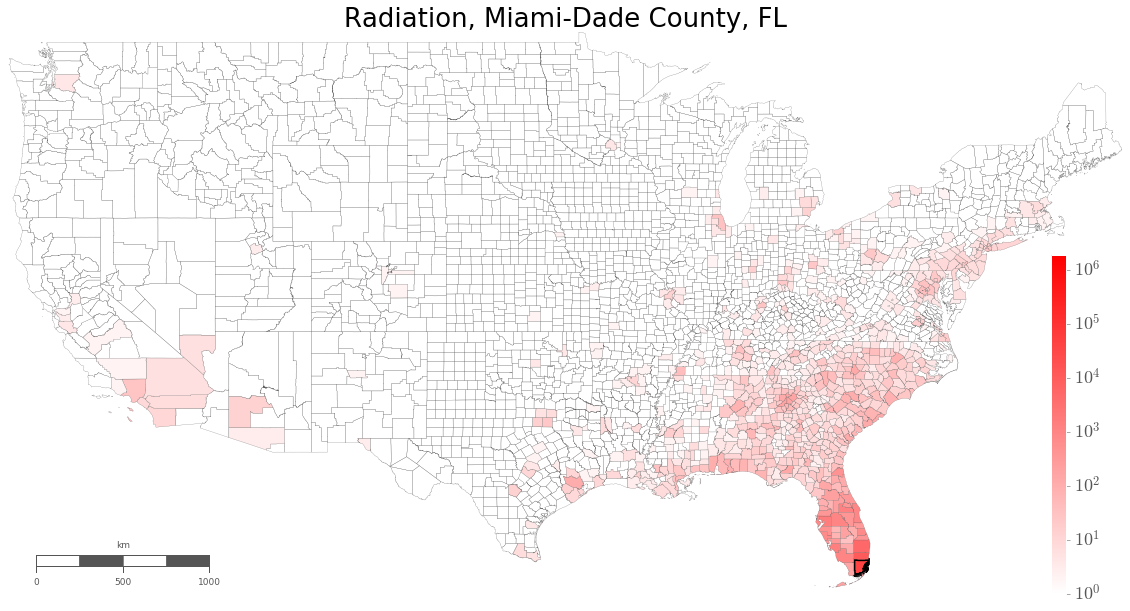

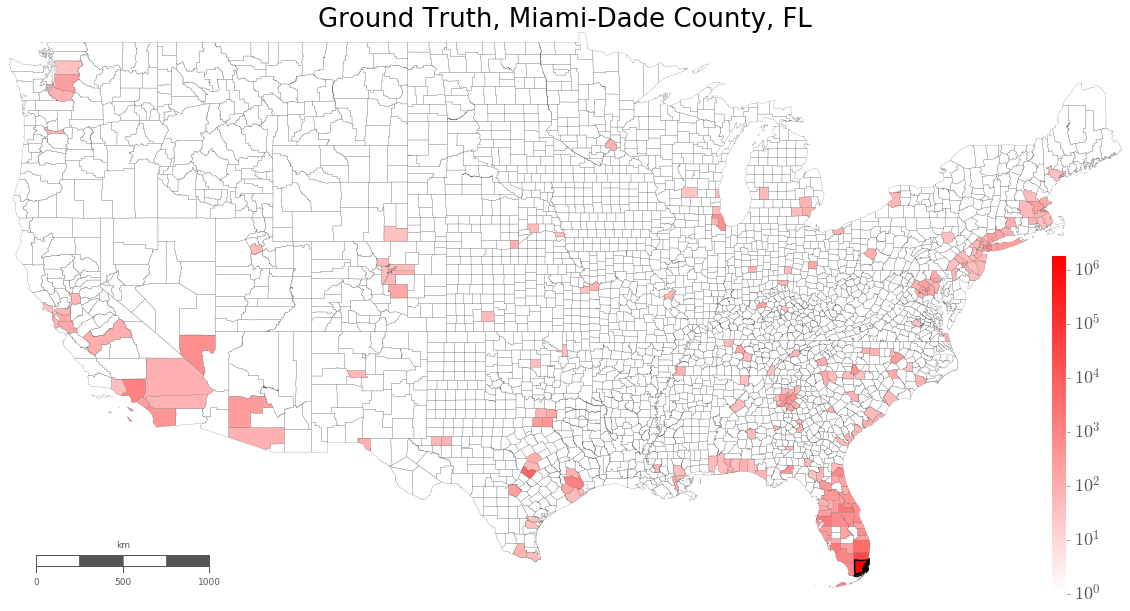

In [102]:
#Radiation Data
interestedData = radiationOutput[interestedIndex,:]
dataRadiation = {
    countyId:(interestedData[i]) 
    for i,countyId in enumerate(countyIds)
}

#Baseline Data
interestedData = baselineOutput[interestedIndex,:]
dataBaseline = {
    countyId:(interestedData[i]) 
    for i,countyId in enumerate(countyIds)
}

colorBar = (1, max(max(dataBaseline.values()),max(dataRadiation.values())))


figureObj.plotSingleMap(
    "Radiation, %s" % (interestedName),
    os.path.join(figureOutputDir,"fig2_radiation.png"),
    dataRadiation,
    colorBar,
    showFig=True,
    highlightId=interestedCountyId
)

figureObj.plotSingleMap(
    "Ground Truth, %s" % (interestedName),
    os.path.join(figureOutputDir,"fig2_baseline.png"),
    dataBaseline,
    colorBar,
    showFig=True,
    highlightId=interestedCountyId
)


1869416.0


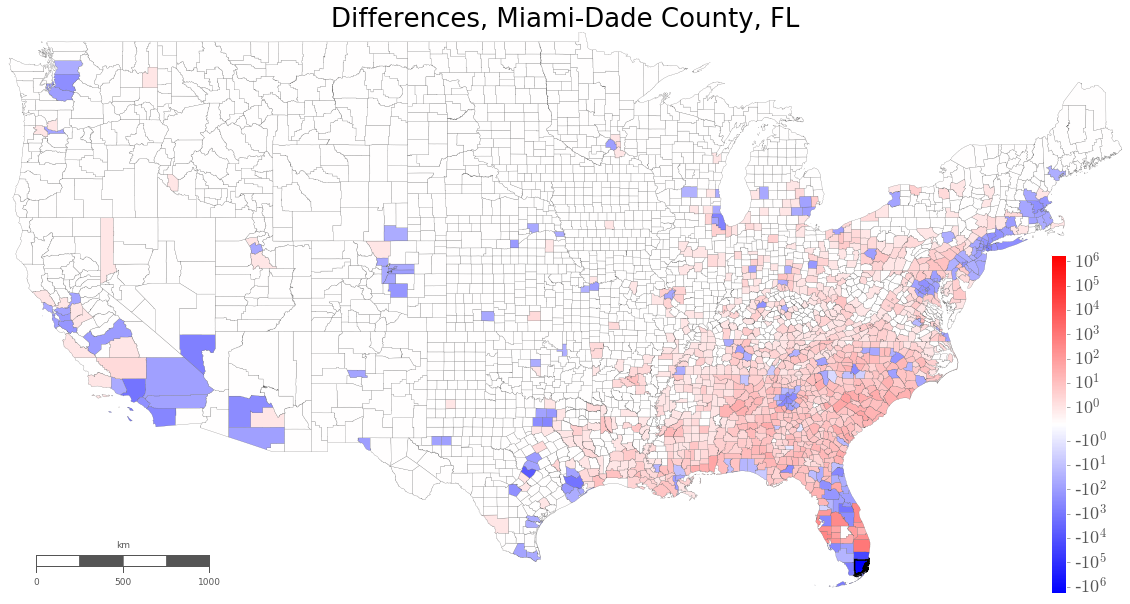

In [103]:
dataDifference = {
    countyId: dataRadiation[countyId] - dataBaseline[countyId]
    for i,countyId in enumerate(countyIds)
}
colorBarAbs = max(np.abs(dataDifference.values()))
print colorBarAbs

figureObj.plotDifferenceMap(
    "Differences, %s" % (interestedName), 
    os.path.join(figureOutputDir,"fig2_difference.png"),
    dataDifference,
    colorBarAbs, 
    highlightId=interestedCountyId, 
    showFig=True
)

# Figure 3

Comparing the different radiation output scenarios to the baseline scenario.

In [105]:
print seaLevelRiseRange

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [106]:
seaLevelRiseIndex = 2
seaLevelRiseAmount = seaLevelRiseRange[seaLevelRiseIndex]
print "Running comparison for a sea level rise of %d meters" % (seaLevelRiseAmount)
dependentOutput = radiationOutputs[0][seaLevelRiseIndex]
baselineOutput = radiationOutputs[0][0]

assert dependentOutput.shape[0] == baselineOutput.shape[0] and dependentOutput.shape[1] == baselineOutput.shape[1]

distanceValues= []
for rowIndex in range(dependentOutput.shape[0]):
    distance = scipy.spatial.distance.euclidean(dependentOutput[rowIndex,:],baselineOutput[rowIndex,:])
    distanceValues.append(distance)
    
minIndexes = np.argsort(distanceValues)
for i in range(-40,0):
    #index = minIndexes[i]
    #print i, index, countyIndex_IdMap[index], countyNameMapping[countyIndex_IdMap[index]], distanceValues[index]
    pass
    
#lats = (24.396308, 49.384358)
#lons = (-124.848974, -66.885444)

lats = (24.01, 36.53)
lons = (-99.76, -74.62)

figureObj = Figures.Mapping(lats, lons, "data/countyBoundaries/countyBoundaries2.shp", goodCounties)
interestedIndex = -37
interestedIndex = minIndexes[interestedIndex]
interestedIndex = countyIdMap[12086] 
interestedCountyId = countyIndex_IdMap[interestedIndex]
interestedName = countyNameMapping[interestedCountyId]

Running comparison for a sea level rise of 2 meters


## Southeast, where do the migrants from the most different county go?

In [107]:
#Radiation Data
interestedData = dependentOutput[interestedIndex,:]
dataRadiation = {
    countyId:(interestedData[i]) 
    for i,countyId in enumerate(countyIds)
}

print "Population in interested county: %d" % (interestedData[interestedIndex])
print "Total row: %d" % (sum(interestedData))
print "Fraction staying in interested county: %0.4f" % (interestedData[interestedIndex]/float(sum(interestedData)))


print "Population migrating to 22071: %d" % (interestedData[countyIdMap[22071]])
print "Population migrating to 22087: %d" % (interestedData[countyIdMap[22087]])

#Baseline Data
interestedData = baselineOutput[interestedIndex,:]
dataBaseline = {
    countyId:(interestedData[i]) 
    for i,countyId in enumerate(countyIds)
}

print "----------------"
print "Population in interested county: %d" % (interestedData[interestedIndex])
print "Total row: %d" % (sum(interestedData))
print "Fraction staying in interested county: %0.4f" % (interestedData[interestedIndex]/float(sum(interestedData)))

print "Population migrating to 22071: %d" % (interestedData[countyIdMap[22071]])
print "Population migrating to 22087: %d" % (interestedData[countyIdMap[22087]])

colorBar = (1, max(max(dataBaseline.values()),max(dataRadiation.values())))

'''
figureObj.plotSingleMap(
    "Radiation model, %d meters sea level rise, %s" % (seaLevelRiseAmount, interestedName),
    "/tmp/test.png",
    dataRadiation,
    colorBar,
    highlightId=interestedCountyId,
    showFig=True
)

figureObj.plotSingleMap(
    "Baseline model, no sea level rise, %s" % (interestedName),
    "/tmp/test.png",
    dataBaseline,
    colorBar,
    highlightId=interestedCountyId,
    showFig=True
)
'''

Population in interested county: 54271
Total row: 107128
Fraction staying in interested county: 0.5066
Population migrating to 22071: 26
Population migrating to 22087: 0
----------------
Population in interested county: 42419
Total row: 83134
Fraction staying in interested county: 0.5102
Population migrating to 22071: 45
Population migrating to 22087: 3


'\nfigureObj.plotSingleMap(\n    "Radiation model, %d meters sea level rise, %s" % (seaLevelRiseAmount, interestedName),\n    "/tmp/test.png",\n    dataRadiation,\n    colorBar,\n    highlightId=interestedCountyId,\n    showFig=True\n)\n\nfigureObj.plotSingleMap(\n    "Baseline model, no sea level rise, %s" % (interestedName),\n    "/tmp/test.png",\n    dataBaseline,\n    colorBar,\n    highlightId=interestedCountyId,\n    showFig=True\n)\n'

11852.0


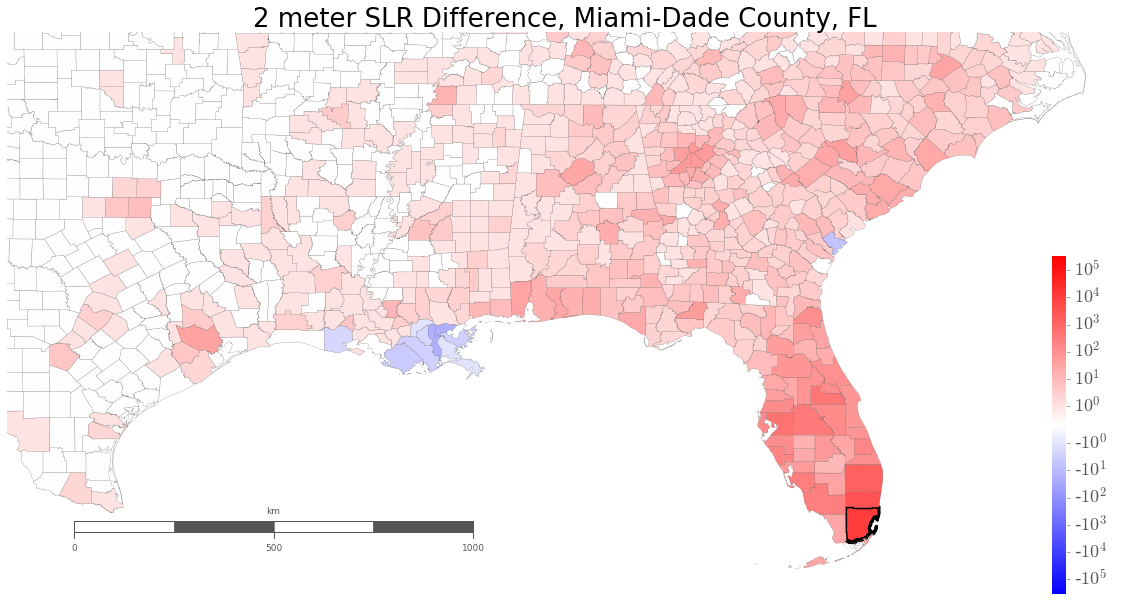

In [108]:
dataDifference = {
    countyId: dataRadiation[countyId] - dataBaseline[countyId]
    for i,countyId in enumerate(countyIds)
}
colorBarAbs = max(np.abs(dataDifference.values()))
print colorBarAbs
colorBarAbs = 350948.0

figureObj.plotDifferenceMap(
    "%d meter SLR Difference, %s" % (seaLevelRiseAmount, interestedName),
    "/tmp/test.png",
    dataDifference,
    colorBarAbs,
    highlightId=interestedCountyId,
    showFig=True
)

## Southeast Incoming Migrants from Affected Areas

In [109]:
#lats = (24.396308, 49.384358)
#lons = (-124.848974, -66.885444)

seaLevelRiseIndex = 2
seaLevelRiseAmount = seaLevelRiseRange[seaLevelRiseIndex]
print "Running comparison for a sea level rise of %d meters" % (seaLevelRiseAmount)
dependentOutput = radiationOutputs[0][seaLevelRiseIndex]
baselineOutput = radiationOutputs[0][0]

assert dependentOutput.shape[0] == baselineOutput.shape[0] and dependentOutput.shape[1] == baselineOutput.shape[1]


affectedCountyIds = []
for k,v in countyPopulationAffected[seaLevelRiseIndex].items():
    if v!=0:
        affectedCountyIds.append(k)

affectedCountyIndices = [countyIdMap[_] for _ in affectedCountyIds]        

#Southeast
lats = (24.01, 36.53)
lons = (-99.76, -74.62)

#Full US
lats = (24.396308, 49.384358)
lons = (-124.848974, -66.885444)

figureObj = Figures.Mapping(lats, lons, "data/countyBoundaries/countyBoundaries2.shp", goodCounties)


#Radiation Data
interestedData = dependentOutput
dataRadiation = {
    countyId:np.sum(interestedData[affectedCountyIndices,i]) 
    for i,countyId in enumerate(countyIds)
}

#Baseline Data
interestedData = baselineOutput
dataBaseline = {
    countyId:np.sum(interestedData[affectedCountyIndices,i]) 
    for i,countyId in enumerate(countyIds)
}

colorBar = (1, max(max(dataBaseline.values()),max(dataRadiation.values())))


'''
figureObj.plotSingleMap(
    "Incoming Migrants from Areas Affected by %d meters Sea Level Rise" % (seaLevelRiseAmount),
    "/tmp/test.png",
    dataRadiation,
    colorBar,
    showFig=True
)

figureObj.plotSingleMap(
    "Incoming Migrants from Areas that Would be Affected by %d meters Sea Level Rise" % (seaLevelRiseAmount),
    "/tmp/test.png",
    dataBaseline,
    colorBar,
    showFig=True
)
'''

Running comparison for a sea level rise of 2 meters


'\nfigureObj.plotSingleMap(\n    "Incoming Migrants from Areas Affected by %d meters Sea Level Rise" % (seaLevelRiseAmount),\n    "/tmp/test.png",\n    dataRadiation,\n    colorBar,\n    showFig=True\n)\n\nfigureObj.plotSingleMap(\n    "Incoming Migrants from Areas that Would be Affected by %d meters Sea Level Rise" % (seaLevelRiseAmount),\n    "/tmp/test.png",\n    dataBaseline,\n    colorBar,\n    showFig=True\n)\n'

In [110]:
dataDifference = {
    countyId: dataRadiation[countyId] - dataBaseline[countyId]
    for i,countyId in enumerate(countyIds)
}
colorBarAbs = max(np.abs(dataDifference.values()))
print colorBarAbs
colorBarAbs = 852507.0
figureObj.plotDifferenceMap(
    "Difference in Incoming Migrants and Baseline Migrants from places affected by %d meter SLR" % (seaLevelRiseAmount),
    "/tmp/test.png",
    dataDifference,
    colorBarAbs,
    showFig=True
)

351847.0


In [111]:
351847.0
712875.0
852507.0

852507.0

### Show amount of affected population

Running vis for: 2
(1, 3000000)


Running vis for: 6
(1, 3000000)


Running vis for: 10
(1, 3000000)


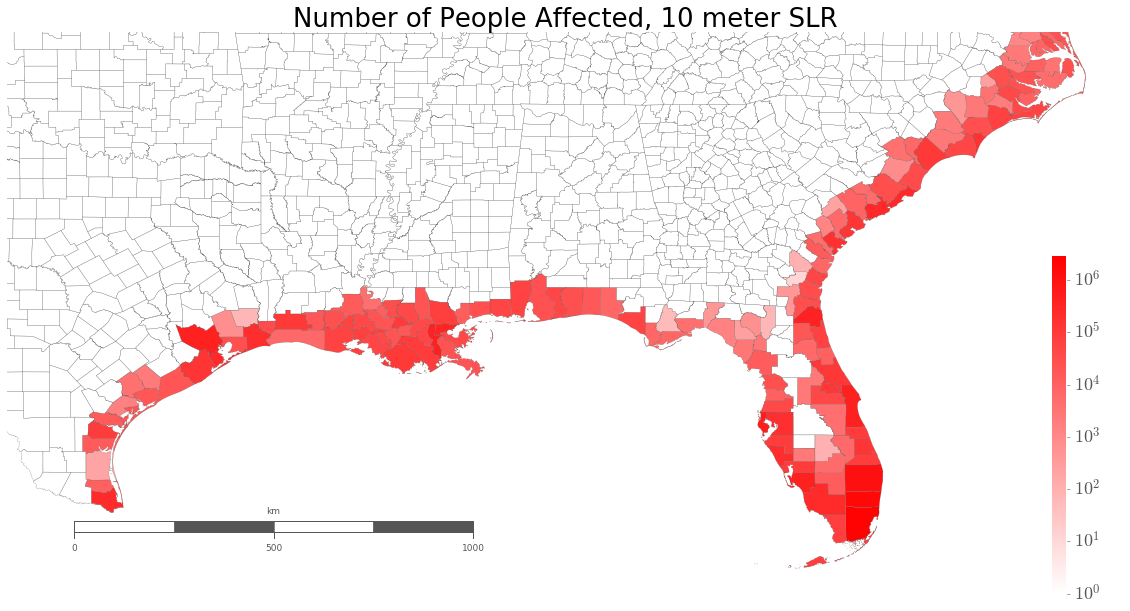

In [114]:
#print countyPopulationAffected[0]
lats = (24.396308, 49.384358)
lons = (-124.848974, -66.885444)

lats = (24.01, 36.53)
lons = (-99.76, -74.62)

figureObj = Figures.Mapping(lats, lons, "data/countyBoundaries/countyBoundaries2.shp", goodCounties)

#for i,x in enumerate(seaLevelRiseRange):
for i,x in [(2,2),(6,6),(10,10)]:
    print "Running vis for: %d" % (x)
    dataOutput = dict()
    for j, countyId in enumerate(goodCounties):
        dataOutput[countyId] = countyPopulationAffected[i][countyId]  * populationDataSets[0][countyIdMap[countyId]]
        
    #print dataOutput
    colorBar = (1, max(dataOutput.values()))
    colorBar = (1,3000000)
    print colorBar
    figureObj.plotSingleMap(
        "Number of People Affected, %d meter SLR" % (x),
        os.path.join(figureOutputDir,"fig3_numAffected_%d_meters.png" % (x)),
        dataOutput,
        colorBar,
        showFig=True,
        useLogScale=True
    )


## Calculate the between county radiation variables

In [ ]:
#print countyPopulationAffected[0]
figureObj = Figures.Mapping(lats, lons, "data/countyBoundaries/countyBoundaries2.shp", goodCounties)

tDataSets = []
for i,x in enumerate(seaLevelRiseRange):
    print "Running vis for: %d" % (x)
    
    dataOutput = dict()
    for j, countyId in enumerate(goodCounties):
        dataOutput[countyId] = countyPopulationAffected[i][countyId] * populationDataSets[0][countyIdMap[countyId]]
    
    print "Population affected 12086 for %d meters SLR: %0.4f" % (x, dataOutput[12086])
    print "Population affected 22071 for %d meters SLR: %0.4f" % (x, dataOutput[22071])
    print "Population affected 22087 for %d meters SLR: %0.4f" % (x, dataOutput[22087])
    tDataSets.append(dataOutput)  

tMaxVal = float('-inf')   
for dataOutput in tDataSets:
    tMaxVal = max(max(dataOutput.values()),tMaxVal)

colorBar = (1,tMaxVal)
for i,x in enumerate(seaLevelRiseRange):
    dataOutput = tDataSets[i]
    figureObj.plotSingleMap("Number of people affected, %d meter SLR" % (x), "/tmp/test.png", dataOutput, colorBar, showFig=True, useLogScale=True)


In [ ]:
debugIds = map(countyIdMap.get,[12086,22071,22087])
print debugIds

tempRadiationOutputs2 = []
for j,x in enumerate(seaLevelRiseRange):
    print "Running radiation model for year %d with a sea level rise of %d" % (2008,x)

    SLAi_over_Ai = countyPopulationAffected[j]
    fitFunction = numMigrantFunctions[0]

    SLAi_over_Ai_converted = []
    for k,countyId in enumerate(countyIds):
        if countyId in SLAi_over_Ai:
            SLAi_over_Ai_converted.append(SLAi_over_Ai[countyId])
        else:
            SLAi_over_Ai_converted.append(0)

    Models.radiationModelDebug(populationDataSets[0], distanceMatrix, SLAi_over_Ai_converted, fitFunction, countyIds, debugIds)
